# Calculate the Flood Ratio and Total Area per AOI 

In [19]:
import ee
ee.Initialize(project='ee-paulhosch')

import geemap
import pandas as pd

import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

In [15]:

# Asset paths
aoi_assets = {
    "AOI 1": 'projects/ee-paulhosch/assets/paper_data/ger/aoi1_2024_06_02_baseImage_rev1',
    "AOI 2": 'projects/ee-paulhosch/assets/paper_data/ger/aoi2_2024_06_02_baseImage_rev1',
    "AOI 3": 'projects/ee-paulhosch/assets/paper_data/ger/aoi3_2024_06_02_baseImage_rev1',
    "AOI 4": 'projects/ee-paulhosch/assets/paper_data/ger/aoi4_2024_06_02_baseImage_rev1',
}


In [20]:

# List to store results
results = []

# Loop through each AOI
for aoi_name, asset_path in aoi_assets.items():
    # Load the image and get label band
    image = ee.Image(asset_path)
    label = image.select('label')
    geometry = image.geometry()

    # Pixel area in km²
    pixel_area = ee.Image.pixelArea().divide(1e6)

    # Compute area per label
    stats = pixel_area.addBands(label).reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName='label'),
        geometry=geometry,
        scale=10,
        maxPixels=1e13
    ).get('groups')

    stats_list = ee.List(stats).getInfo()
    area_dict = {int(item['label']): item['sum'] for item in stats_list}

    # Extract areas
    area_no_water = area_dict.get(0, 0)
    area_flooded = area_dict.get(1, 0)
    area_perm_water = area_dict.get(11, 0)
    total_area = sum(area_dict.values())
    
    # Calculate flood ratio
    flood_ratio = round(area_flooded / area_no_water, 3) if area_no_water > 0 else 0

    results.append({
        'AOI': aoi_name,
        'No Water (0)': round(area_no_water, 2),
        'Flooded (1)': round(area_flooded, 2),
        'Permanent Water (11)': round(area_perm_water, 2),
        'Total Area': round(total_area, 2),
        'Flood Ratio (%)': round(flood_ratio*100, 2)
    })

# Convert results to DataFrame and display
df = pd.DataFrame(results)
display(df)

,AOI,No Water (0),Flooded (1),Permanent Water (11),Total Area,Flood Ratio (%)
0,AOI 1,72.25,2.07,6.55,80.86,2.9
1,AOI 2,70.25,5.81,4.95,81.01,8.3
2,AOI 3,72.52,2.76,5.71,80.99,3.8
3,AOI 4,74.42,2.37,4.08,80.87,3.2


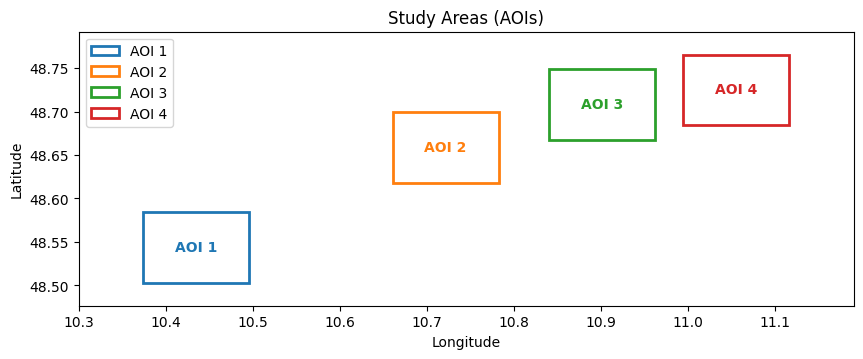

In [21]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Colors for different AOIs
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Store bounding boxes for each AOI
for idx, (aoi_name, asset_path) in enumerate(aoi_assets.items()):
    # Get geometry bounds
    geometry = ee.Image(asset_path).geometry()
    bounds = geometry.bounds().coordinates().get(0).getInfo()
    coords = [(pt[0], pt[1]) for pt in bounds]
    
    # Calculate bounding box coordinates
    minx = min([x for x, y in coords])
    maxx = max([x for x, y in coords])
    miny = min([y for x, y in coords])
    maxy = max([y for x, y in coords])
    
    # Create and plot rectangle
    rect = plt.Rectangle((minx, miny), maxx-minx, maxy-miny,
                        fill=False, color=colors[idx], linewidth=2,
                        label=aoi_name)
    ax.add_patch(rect)
    
    # Add label at center of box
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2
    ax.text(center_x, center_y, aoi_name, 
            horizontalalignment='center',
            verticalalignment='center',
            color=colors[idx],
            fontweight='bold')

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Study Areas (AOIs)')

# Add legend
ax.legend()

# Adjust plot limits with some padding
ax.margins(0.1)

# Use equal aspect ratio to prevent distortion
ax.set_aspect('equal')

plt.show()